In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install stable-baselines3
!pip install torch torchvision torchaudio onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
!ls /content/drive/MyDrive/models/

circuit_rl_model.zip  spwm_rl_model_1.zip  spwm_rl_model.zip


In [7]:
!cp "/content/drive/My Drive/models/spwm_rl_model_1.zip" "/content/"

In [8]:
import torch
from stable_baselines3 import PPO

model_path = "/content/drive/My Drive/models/spwm_rl_model_1.zip"
model = PPO.load(model_path)


In [11]:
import onnx

# Define a dummy input tensor (single modulation index)
dummy_input = torch.tensor([[0.5]], dtype=torch.float32)  # Shape: (batch_size, 1)

# Ensure model is on CPU before export
model.policy.to("cpu")

# Export to ONNX with opset version 12 to avoid unsupported operators
onnx_path = "/content/drive/My Drive/spwm_rl_model.onnx"

torch.onnx.export(
    model.policy,  # The trained PPO policy model
    dummy_input,  # Example input tensor
    onnx_path,  # Output file path
    export_params=True,
    opset_version=12,  # Use ONNX opset 12 to avoid errors
    do_constant_folding=True,  # Optimize model
    input_names=["modulation_index"],
    output_names=["spwm_waveform"],
    dynamic_axes={"modulation_index": {0: "batch_size"}, "spwm_waveform": {0: "batch_size"}}
)

print(f"ONNX model successfully saved at: {onnx_path}")


ONNX model successfully saved at: /content/drive/My Drive/spwm_rl_model.onnx


In [24]:
import onnx

# Load the ONNX model
model_path = "/content/drive/My Drive/spwm_rl_model_fixed.onnx"
model = onnx.load(model_path)

# Remove unsupported layers
for node in model.graph.node:
    if node.op_type == "RandomUniformLike":
        model.graph.node.remove(node)

# Save the modified ONNX model
onnx.save(model, "/content/drive/My Drive/spwm_rl_model_no_random.onnx")
print("Fixed model saved as spwm_rl_model_no_random.onnx")


Fixed model saved as spwm_rl_model_no_random.onnx


In [13]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
session = ort.InferenceSession(onnx_path)

# Run inference with a sample modulation index
input_data = np.array([[0.5]], dtype=np.float32)
outputs = session.run(None, {"modulation_index": input_data})

print("Predicted SPWM waveform:", outputs[0])


Predicted SPWM waveform: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
  1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
  1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
  0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
  0. 0. 1. 1.

In [15]:
import onnx

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)  # Verifies model correctness

print("ONNX model is valid and ready for MATLAB!")


ONNX model is valid and ready for MATLAB!


# TESTING

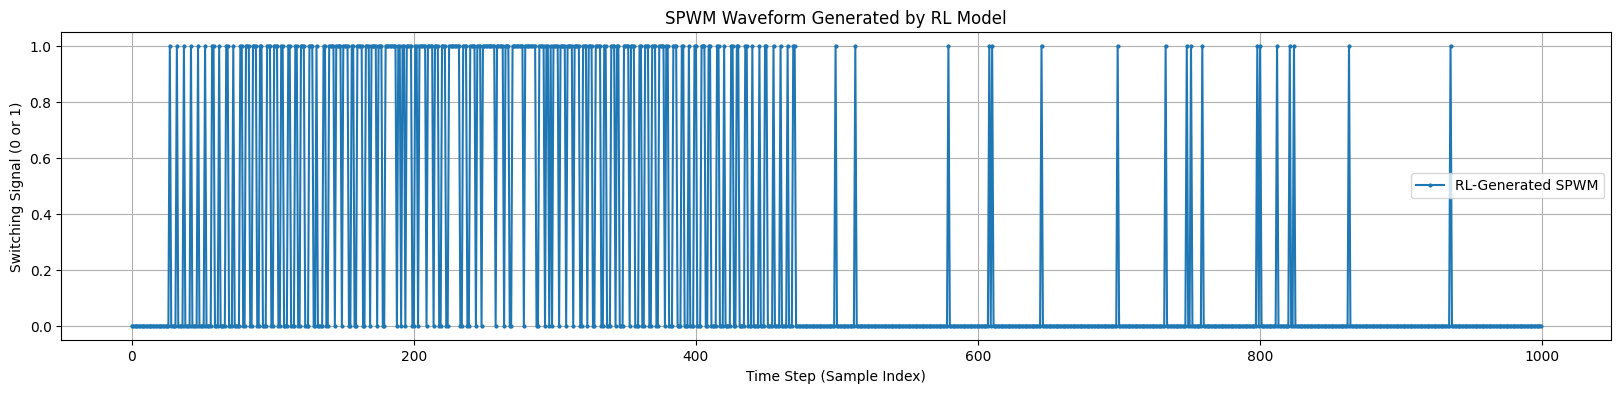

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Test modulation index
test_modulation_index = np.array([[0.8]])  # 2D array required for model input

# Get RL model's predicted SPWM action
action, _ = model.predict(test_modulation_index)

# Plot the generated SPWM waveform
plt.figure(figsize=(20, 4))
plt.plot(action[0], label="RL-Generated SPWM", linestyle='-', marker='o', markersize=2)
plt.title("SPWM Waveform Generated by RL Model")
plt.xlabel("Time Step (Sample Index)")
plt.ylabel("Switching Signal (0 or 1)")
plt.legend()
plt.grid(True)
plt.show()


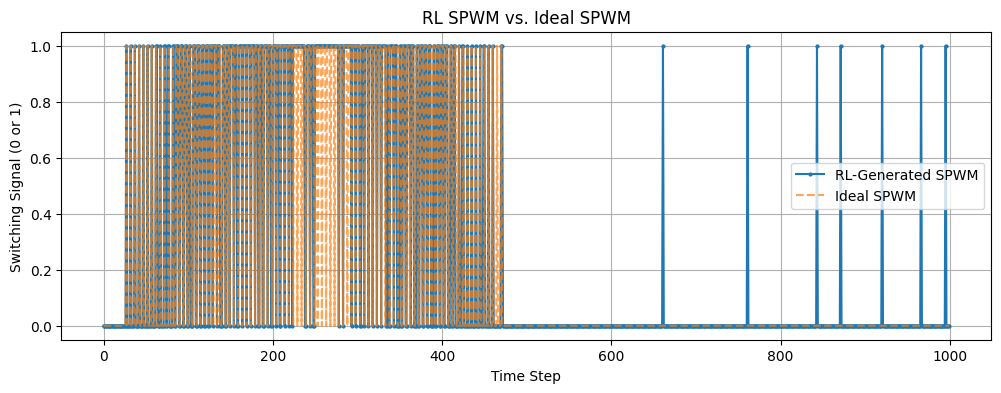

In [ ]:
# Generate ideal sine wave
t = np.linspace(0, 1/50, 1000)  # Time vector (50 Hz fundamental frequency)
ideal_sin_wave = test_modulation_index[0, 0] * np.sin(2 * np.pi * 50 * t)

# Generate carrier wave (60kHz triangular wave)
carrier_wave = 2 * np.abs(np.mod(60000 * t, 1) - 0.5)

# Ideal SPWM generation
ideal_spwm = (ideal_sin_wave > carrier_wave).astype(np.float32)

# Plot comparison
plt.figure(figsize=(12, 4))
plt.plot(action[0], label="RL-Generated SPWM", linestyle='-', marker='o', markersize=2)
plt.plot(ideal_spwm, label="Ideal SPWM", linestyle='--', alpha=0.7)
plt.title("RL SPWM vs. Ideal SPWM")
plt.xlabel("Time Step")
plt.ylabel("Switching Signal (0 or 1)")
plt.legend()
plt.grid(True)
plt.show()
